In [6]:
!git clone https://github.com/salesforce/BLIP
!pip install fairscale
!pip install transformers
%cd BLIP

Clonage dans 'BLIP'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 277 (delta 145), reused 137 (delta 137), pack-reused 94 (from 1)
Réception d'objets: 100% (277/277), 7.04 Mio | 24.93 Mio/s, fait.
Résolution des deltas: 100% (152/152), fait.
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 38.9 MB/s eta 0:00:00 0:00:01
Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
/home/paul/Cours/BGDIA708/Projet-IA-Fairness/Grad-Eclip-main/BLIP/BLIP/BLIP


In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
%matplotlib inline

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ]) 


_transform = Compose([
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])
def imgprocess_keepsize(img, patch_size=[16, 16], scale_factor=1):
    w, h = img.size
    ph, pw = patch_size
    nw = int(w * scale_factor / pw + 0.5) * pw
    nh = int(h * scale_factor / ph + 0.5) * ph

    ResizeOp = Resize((nh, nw), interpolation=InterpolationMode.BICUBIC)
    img = ResizeOp(img).convert("RGB")
    return _transform(img)

In [7]:
from models.blip_itm import BLIP_ITM
from models.blip import load_checkpoint
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
model = BLIP_ITM(image_size=224, vit='base')
model, msg = load_checkpoint(model, model_url)
model.to(device)
assert(len(msg.missing_keys)==0)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 1.78G/1.78G [00:49<00:00, 38.3MB/s]


reshape position embedding from 576 to 196
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth


In [8]:
## original setting
img_size = 224
patch_size=16
embed_dim=768
num_heads=12

## use one head in last layer
num_heads_last = 1

def blip_img_encoder(x):
    vit = model.visual_encoder
    x = vit.patch_embed.proj(x)
    B, C, feah, feaw = x.shape
    
    x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
    x = vit.patch_embed.norm(x)    
    cls_tokens = vit.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
    x = torch.cat((cls_tokens, x), dim=1)
    
    ### resize position embedding 
    pos_embedding = vit.pos_embed[0,:x.size(1),:]
    tok_pos, img_pos = pos_embedding[:1, :], pos_embedding[1:, :]
    pos_h = img_size // patch_size
    pos_w = img_size // patch_size
    assert img_pos.size(0) == (pos_h * pos_w), f"the size of pos_embedding ({img_pos.size(0)}) does not match resolution shape pos_h ({pos_h}) * pos_w ({pos_w})"
    img_pos = img_pos.reshape(1, pos_h, pos_w, img_pos.shape[1]).permute(0, 3, 1, 2)
    img_pos = torch.nn.functional.interpolate(img_pos, size=(feah, feaw), mode='bicubic', align_corners=False)
    img_pos = img_pos.reshape(1, img_pos.shape[1], -1).permute(0, 2, 1)
    pos_embedding = torch.cat((tok_pos[None, ...], img_pos), dim=1)
    x = x + pos_embedding
    x = vit.pos_drop(x)

    for i,blk in enumerate(vit.blocks[:-1]):
        x = blk(x)

    ## The last Transformer
    x_in = x
    lastTR = vit.blocks[-1]
    x = lastTR.norm1(x_in)
    
    B, N, C = x.shape
    qkv = lastTR.attn.qkv(x).reshape(B, N, 3, num_heads_last, C // num_heads_last).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

    attn = (q @ k.transpose(-2, -1)) * lastTR.attn.scale
    attn = attn.softmax(dim=-1)
    attn = lastTR.attn.attn_drop(attn)
    attn_out = (attn @ v).transpose(1, 2).reshape(B, N, C)
    
    x = lastTR.attn.proj(attn_out)
    x = lastTR.attn.proj_drop(x)
    x = x_in + lastTR.drop_path(x)
    x = x + lastTR.drop_path(lastTR.mlp(lastTR.norm2(x)))
    
    x = vit.norm(x)
    x = model.vision_proj(x[:,0,:])
    return x, attn_out, (q.detach(), k.detach(), v.detach()), (feah, feaw)


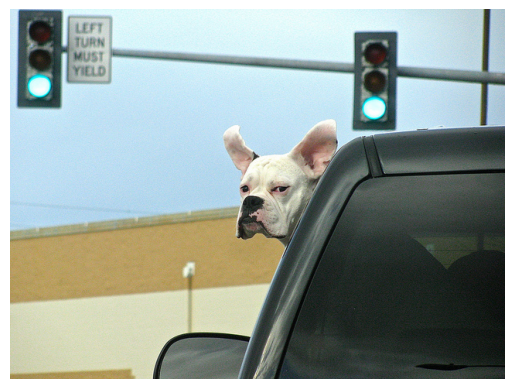

In [12]:
img_path = "../../../dog_and_car.png"
caption = "a dog in a car waiting for traffic lights"

img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.axis('off')
plt.show()

In [13]:
img_keepsizeprocess = imgprocess_keepsize(img).unsqueeze(0).to(device)
text = model.tokenizer(caption, padding='max_length', truncation=True, max_length=35, 
                              return_tensors="pt").to(device) 
text_output = model.text_encoder(text.input_ids, attention_mask = text.attention_mask,                      
                                            return_dict = True, mode = 'text') 
text_feature = F.normalize(model.text_proj(text_output.last_hidden_state[:,0,:]), dim=-1)
print(text_feature.shape)

torch.Size([1, 256])


In [14]:
img_feature, last_att_outputs, (q,k,v), map_size = blip_img_encoder(img_keepsizeprocess)
img_feature = F.normalize(img_feature, dim=-1)
print(img_feature.shape)
cosines = (img_feature @ text_feature.t())[0]
print(cosines)

torch.Size([1, 256])
tensor([0.2420], device='cuda:0', grad_fn=<SelectBackward0>)


In [15]:
def grad_eclip(c, q, k, v, att_output, map_size, withksim=True):
    D = k.shape[-1]
    ## gradient on last attention output
    grad = torch.autograd.grad(
        c,
        att_output,
        retain_graph=True)[0]
    grad = grad.detach()
    print(grad.shape)
    print(q.shape, k.shape, v.shape)
    grad_cls = grad[0,:1,:]
    if withksim:
        q_cls = q[0,0,:1,:]
        k_patch = k[0,0,1:,:]
        q_cls = F.normalize(q_cls, dim=-1)
        k_patch = F.normalize(k_patch, dim=-1)
        cosine_qk = (q_cls * k_patch).sum(-1) 
        cosine_qk = (cosine_qk-cosine_qk.min()) / (cosine_qk.max()-cosine_qk.min())
        emap_lastv = F.relu_((grad_cls * v[0,0,1:,:] * cosine_qk[:,None]).detach().sum(-1)) # 
    else:
        emap_lastv = F.relu_((grad_cls * v[0,0,1:,:]).detach().sum(-1)) 
    return emap_lastv.reshape(*map_size)

def visualize(hmap, raw_image, resize):
    hmap -= hmap.min()
    hmap /= hmap.max()
    image = np.asarray(raw_image.copy())
    hmap = resize(hmap.unsqueeze(0))[0].cpu().numpy()
    color = cv2.applyColorMap((hmap*255).astype(np.uint8), cv2.COLORMAP_JET) # cv2 to plt
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    c_ret = np.clip(image * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
    return c_ret

In [16]:
emap = grad_eclip(cosines[0], q, k, v, last_att_outputs, map_size, withksim=True)

torch.Size([1, 1201, 768])
torch.Size([1, 1, 1201, 768]) torch.Size([1, 1, 1201, 768]) torch.Size([1, 1, 1201, 768])


640 478


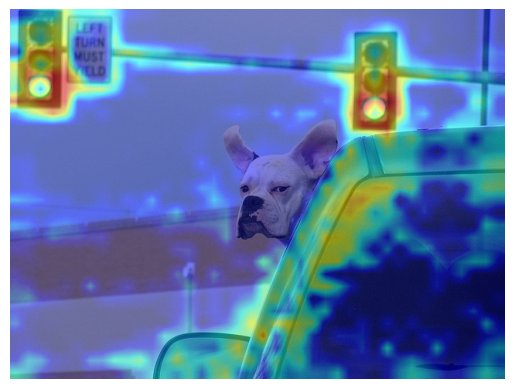

In [17]:
w, h = img.size
print(w,h)
resize = Resize((h,w))

c_ret = visualize(emap, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()